In [1]:
import cv2,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from poe.bulk.predictions import *
from itertools import groupby
from pathlib import Path 
from poe.bulk.image_cutter import *
import hashlib
plt.style.use('dark_background')
%matplotlib inline

poe/bulk/data/tabs/unknown.png 65e5ff54b3
0


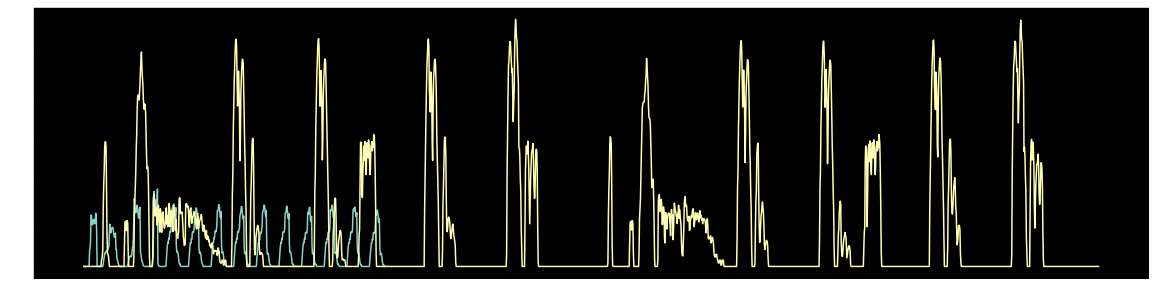

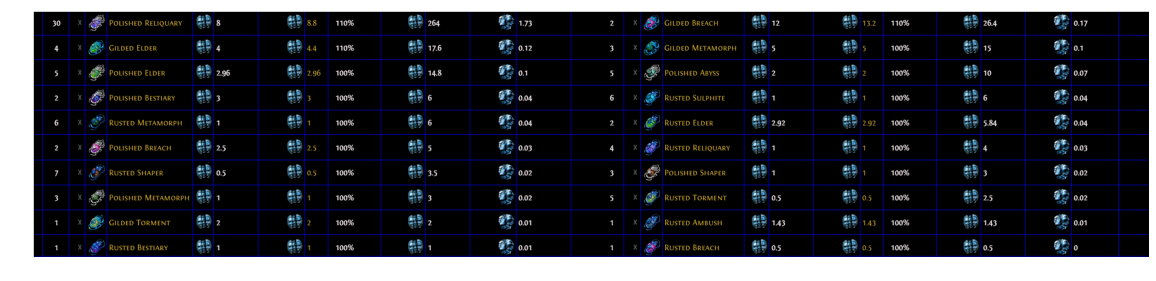

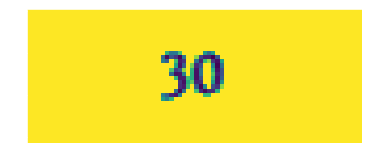

['30']


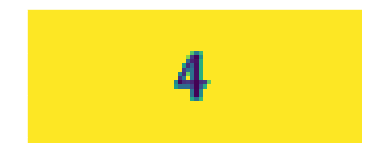

['44']


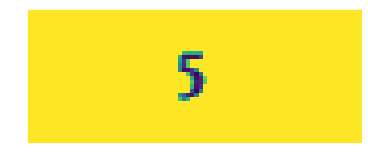

['5']


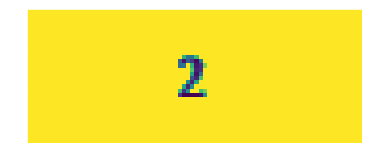

['2']


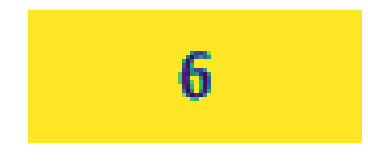

['6']


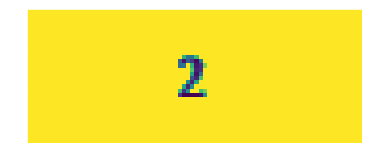

['2']


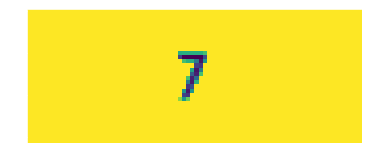

['7']


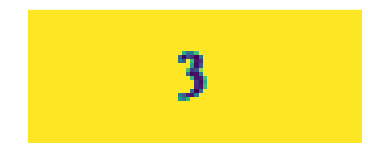

['3']


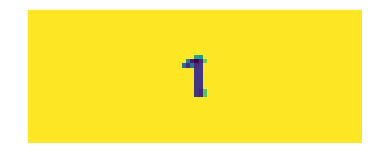

['1']


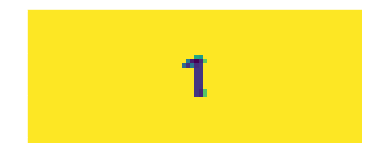

['1']


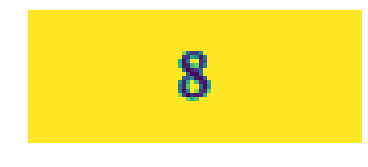

['8']


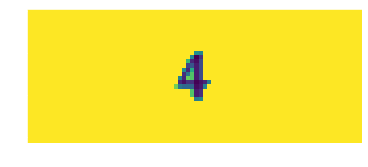

['44']


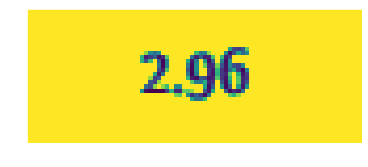

['2.96']


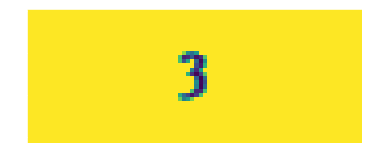

['3']


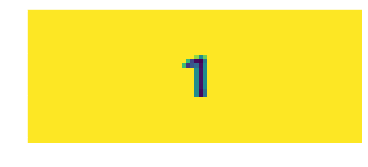

['1']


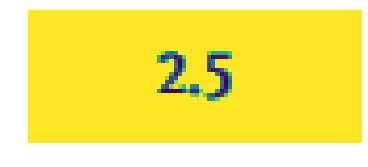

['2.5']


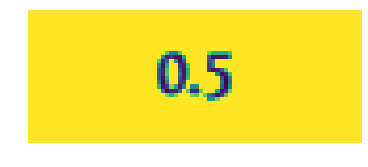

['0.5']


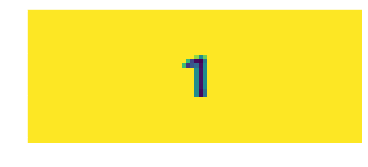

['1']


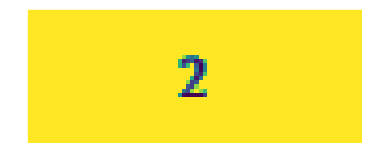

['2']


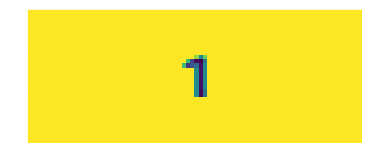

['1']


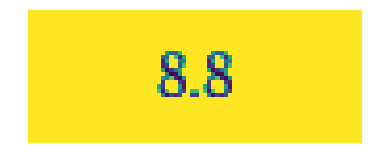

['8.8']


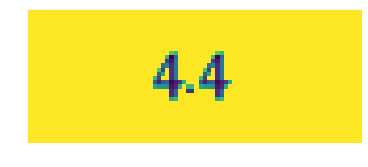

['4.4']


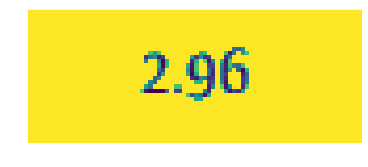

['2.96']


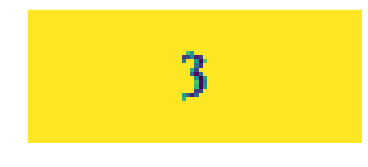

['3']


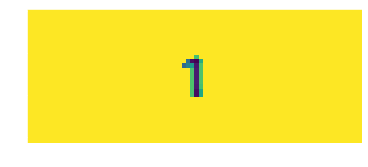

['1']


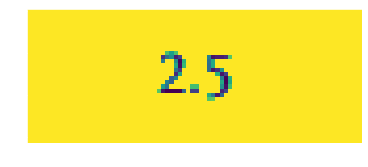

['2.5']


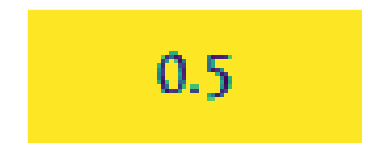

['0.5']


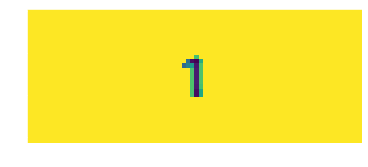

['1']


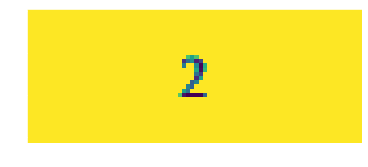

['2']


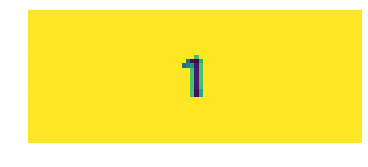

['1']


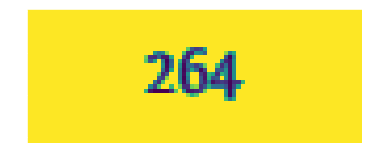

['264']


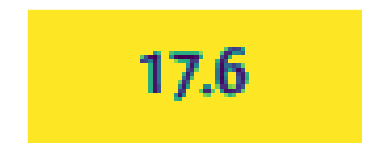

['17.6']


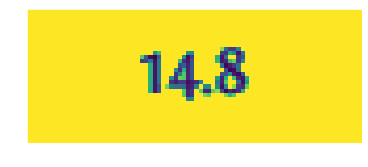

['14.8']


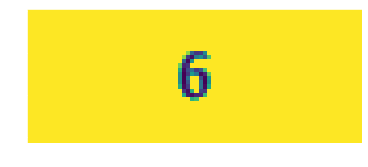

['6']


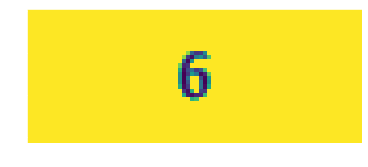

['6']


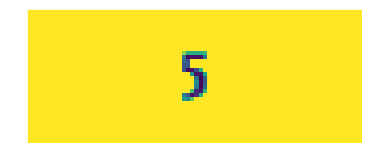

['5']


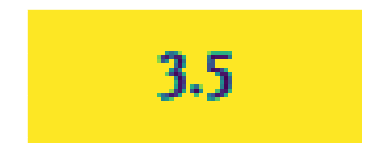

['3.5']


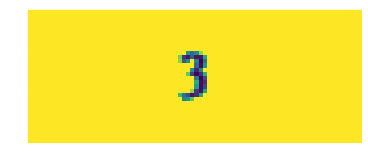

['3']


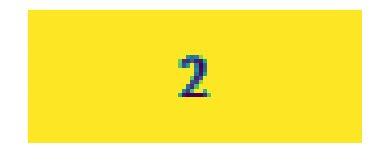

['2']


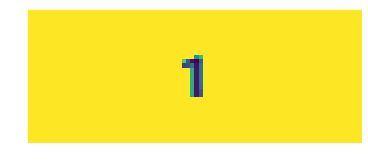

['1']


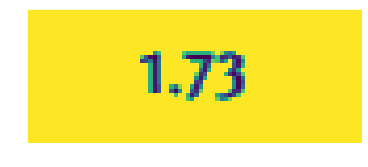

['1.73']


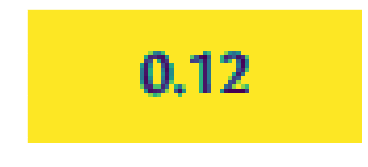

['0.12']


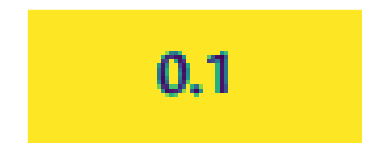

['0.1']


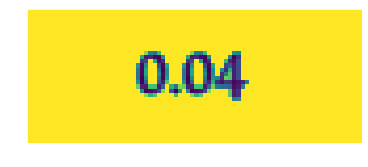

['0.04']


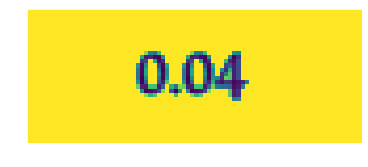

['0.04']


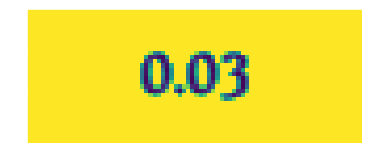

['0.03']


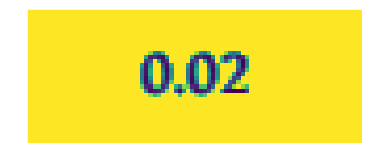

['0.02']


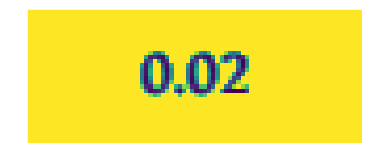

['0.02']


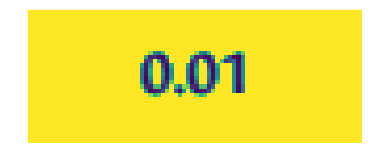

['0.01']


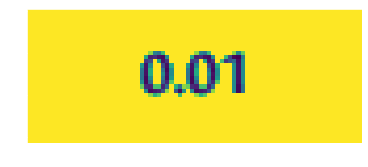

['0.01']


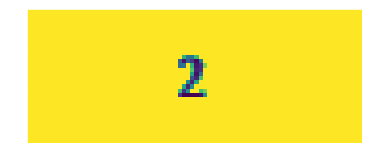

['2']


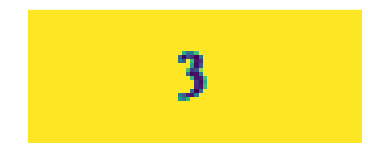

['3']


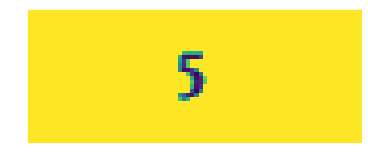

['5']


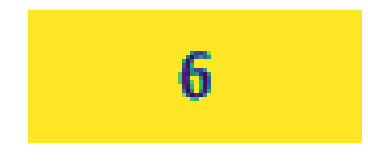

['6']


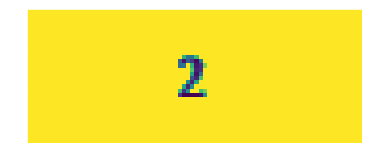

['2']


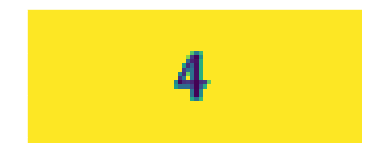

['44']


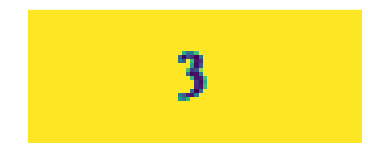

['3']


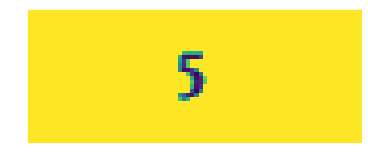

['5']


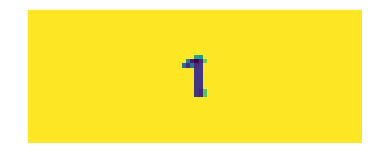

['1']


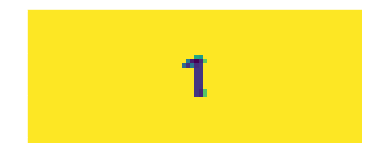

['1']


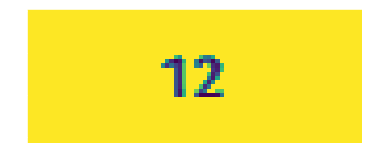

['12']


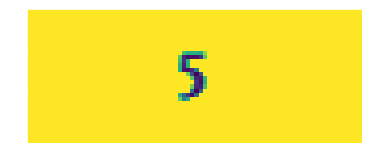

['5']


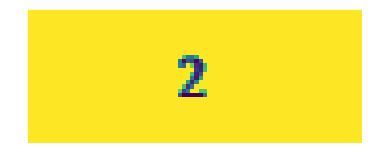

['2']


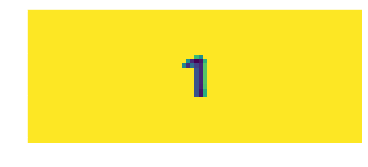

['1']


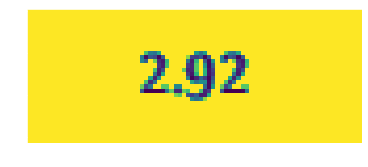

['2.92']


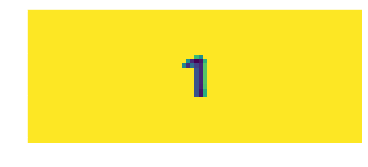

['1']


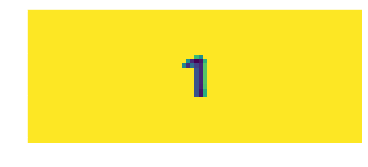

['1']


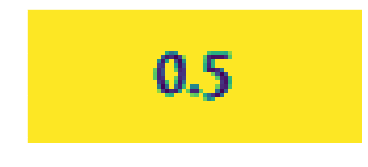

['0.5']


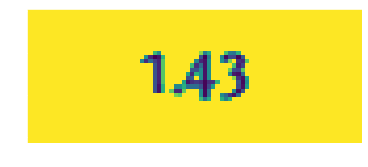

['1.43']


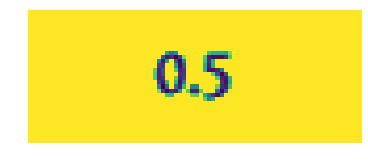

['0.5']


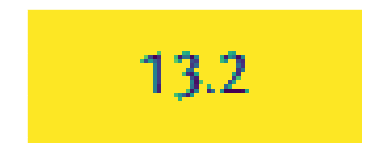

['13.2']


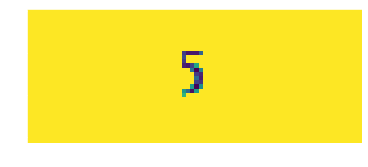

['5']


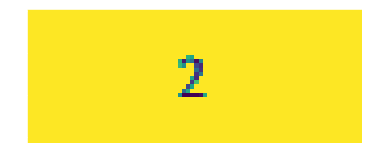

['2']


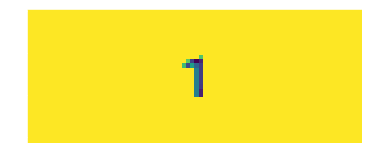

['0']


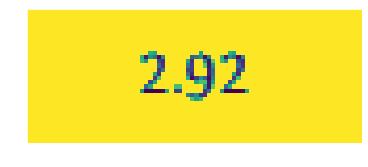

['2.92']


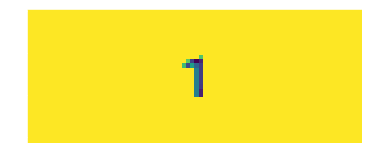

['0']


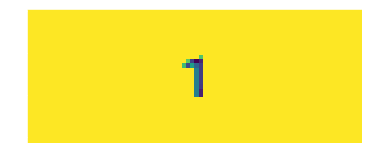

['0']


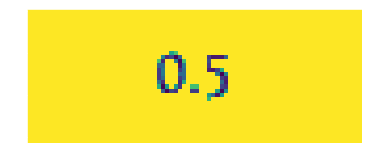

['0.5']


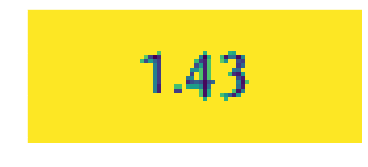

['1.43']


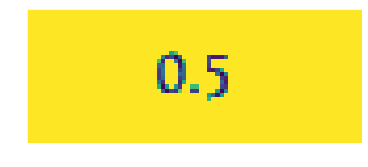

['0.5']


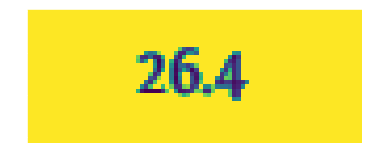

['26.4']


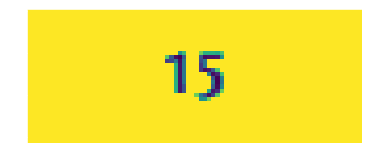

['15']


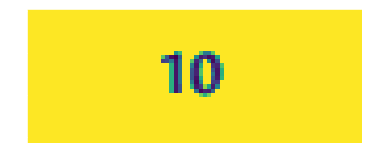

['10']


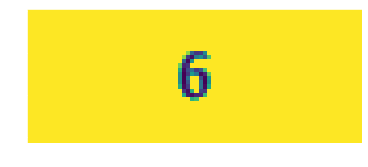

['6']


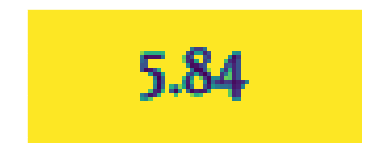

['5.84']


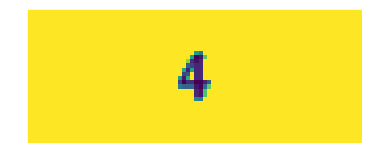

['44']


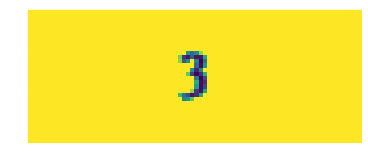

['3']


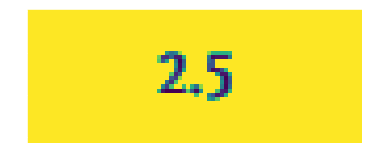

['2.5']


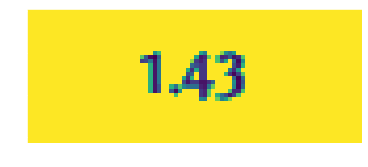

['1.43']


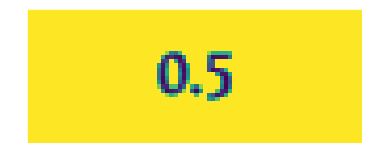

['0.5']


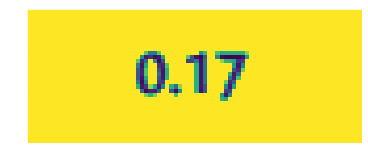

['0.17']


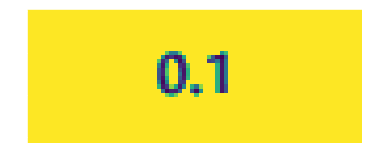

['0.1']


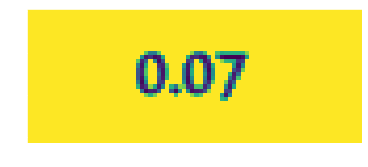

['0.07']


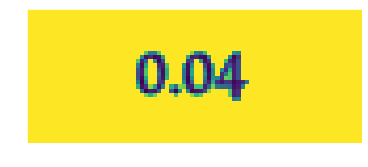

['0.04']


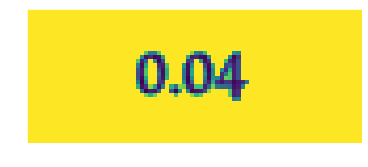

['0.04']


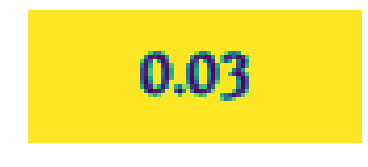

['0.03']


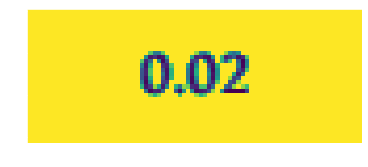

['0.02']


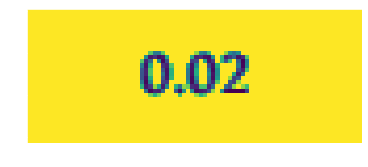

['0.02']


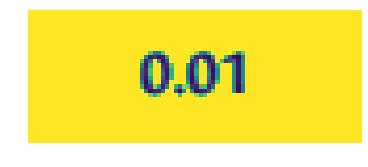

['0.01']


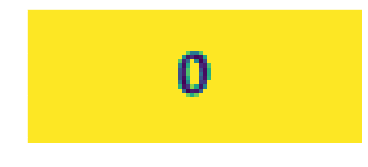

['0']


In [3]:
path='poe/bulk/data/tabs/unknown.png'

cols_of_interest=[1,6,8,11,13,14,19,21,24,26]
img_hash=hashlib.sha224(str(path).encode()).hexdigest()[:10]
print(path,img_hash)
img=cv2.imread(path)
assert img.shape[0]*img.shape[1]>0
try:
    frags=cut_image_to_frags(img)
except Exception as e: 
    print(f'{path,img_hash} could not be processed:{e}')
    plt.figure(figsize=(20,20))
    plt.imshow(img)
for col in cols_of_interest:
    for row,frag in enumerate(frags[col]):
        _frag=normalize_frag(frag,target=(32,80))
        result = predict_wrapper(_frag)

        plt.figure()
        plt.imshow(_frag)
        plt.show()
        print(result)
